In [1]:
# !pip3 install -U https://api.github.com/repos/saffy-team/saffy/zipball/master --user

In [1]:
'''IMPORTY'''

import numpy as np
from scipy.stats import pearsonr
import scipy.signal as ss
import scipy.stats as scst
import saffy
from saffy.generators.svarog import svarog
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
%matplotlib inline

In [35]:
'''FUNKCJE'''


def koreluj(s1, s2, Fs): #delta - ile przesunięć
    
    'korelacja robiona na zajeciach z wzorów'
    s1 = s1.copy()
    s2 = s2.copy()
    delta = int(Fs/2)
    gammy = np.zeros(2*delta+1)
    N = len(s1)
    for i in range(-delta, delta+1):
        if i < 0:
            s1_temp=s1[0:N+i]
            s2_temp=s2[-i:N]
        else:
            s1_temp=s1[i:N]
            s2_temp=s2[0:N-i]
        gamma = np.sum((s1_temp - np.mean(s1)) *(s2_temp - np.mean(s2)))/(N-1)
        gamma = gamma  / (np.std(s1,ddof=1)*np.std(s2,ddof=1))
        gammy[delta+i] = gamma
    return gammy

def rysuj_koreluj(M_syg , CH_names ,  ch , delta , start , stop , up = 0, down = 0):
    KORELACJE = np.empty( ( ch , ch , delta+1) )

    for i in range(ch):
        for j in range(ch):
        
            KORELACJE[i,j,:] = koreluj(M_syg[i,start:stop] , M_syg[j,start:stop] , delta)
            ax1 = plt.subplot( ch, ch , ( (i*ch) + j+1 ) )
            plt.title(CH_names[i] + 'x' + CH_names[j])
            plt.axhline(0, color = 'g')
            if up:
                plt.axhline(up, color = 'r')
            if down:
                plt.axhline(down, color = 'r')
            plt.ylim(-1,1)
            ax1.plot(KORELACJE[i,j])
        
    plt.show()
    return KORELACJE

def fourier(kor, F , Fs):
    
    'fourier z wzorów na zajęciach'
    
    s = np.zeros(len(F),dtype=complex)
    s2 = np.zeros(len(F),dtype=complex)
    for i,f in enumerate(F):
        a=0
        for tau, gamma in enumerate(kor):
            t = (tau-(len(kor)-1)/2)/Fs
            a += gamma*np.exp(-2*np.pi*1j*f*t)
        s[i] = np.absolute(a)
        s2[i] = a
    return s , s2

def cool_koreluj(syg1,syg2):
    
    'korelacja liczona przy pomocy dostępnych bibliotek, odpowiednio normalizowana wg wzorów.'
    
    S1 = syg1 - np.mean(syg1)
    S2 = syg2 - np.mean(syg2)
    norm = np.std(syg1) * np.std(syg2) * len(syg1)
    korelacja = ss.correlate( S1 , S2 , mode = 'same' , method = 'direct') / norm
    return korelacja

def rysuj_cool_koreluj(M_syg ,CH_names , ch , start , stop , up = 0 , down = 0 ):
    KORELACJE2 = np.empty( ( ch, ch , (stop-start+1) ) )

    for i in range(ch):
        for j in range(ch):

            KORELACJE2[i,j,:] = cool_koreluj( M_syg[i,start:stop+1] , M_syg[j,start:stop+1 ] )

            ax1 = plt.subplot(ch, ch, ( i*ch) + j + 1 )
            plt.title(f" {CH_names[i]} x {CH_names[j]}")
            
            plt.axhline(0, color = 'g')
            if up:
                plt.axhline(up, color = 'r')
            if down:
                plt.axhline(down, color = 'r')
            plt.ylim(-1,1)
            ax1.plot(KORELACJE2[i,j])
    fig = plt.figure(figsize = (50,50))
    plt.show()
    return KORELACJE2

def przedzialy(M_syg , ch , start , stop , N): 
    max_corr = np.zeros(N)
    M_syg = M_syg.copy()
    for k in range(N):
        corr_matrix = np.zeros((ch**2,(stop-start)))
        for i in range(ch):
            for j in range(ch):
                syg1 = M_syg[i,start:stop]
                syg2 = M_syg[j,start:stop]
                np.random.shuffle(syg1)
                np.random.shuffle(syg2)  
                corr_matrix[(i*ch)+j,:] = cool_koreluj(syg1 , syg2)

                if i == j:
                    corr_matrix[(i*ch)+j,int((stop-start)/2)] = 0

        max_corr[k] = np.max(np.abs(corr_matrix))
    return max_corr , np.percentile(max_corr, 95) , -np.percentile(max_corr, 95)

In [12]:
print(np.empty(40))

[0.15 0.15 0.15 1.   0.15 0.15 0.15 1.   0.15 0.15 0.15 1.   0.15 0.15
 0.15 1.   0.15 0.15 0.15 1.   0.15 0.15 0.15 1.   0.15 0.15 0.15 1.
 0.15 0.15 0.15 1.   0.15 0.15 0.15 1.   0.15 0.15 0.15 1.  ]


długość sygnału sin: 256
długość autokorealcji z zajęć: 65, przy delcie = 64


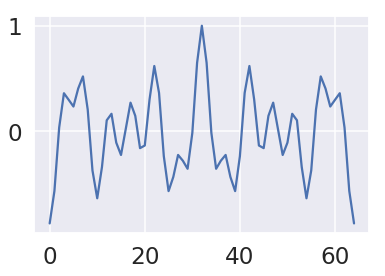

długość autokorealcji mądrej: 256


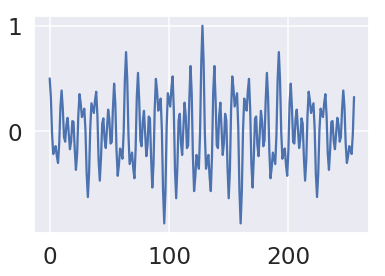

In [31]:
'''         TESTY

    autokorelacja sinusa'''

Fs = 64
t = np.arange(0,4,1/Fs)
s = np.sin(2*np.pi*t*5) + np.sin(2*np.pi*t*7) + np.sin(2*np.pi*t*13) 
czestosci = np.arange(0,Fs/2, 0.01)
print(f"długość sygnału sin: {len(s)}")

kor = koreluj(s,s,Fs)
print(f"długość autokorealcji z zajęć: {len(kor)}, przy delcie = {Fs}")
plt.plot(kor)
plt.show()

kor2 = cool_koreluj(s,s)
print(f"długość autokorealcji mądrej: {len(kor2)}")
plt.plot(kor2)
plt.show()
# plt.plot(czestosci, fourier(kor, czestosci), color = "green")

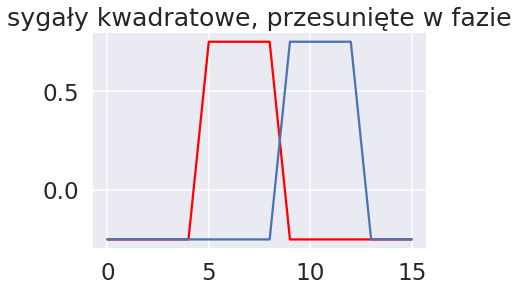

długość sygnałów 16


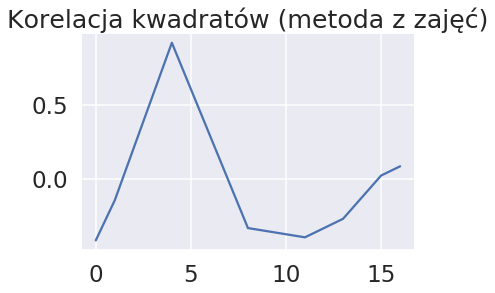

długość korealcji z zajęć: 17, przy delcie = 16


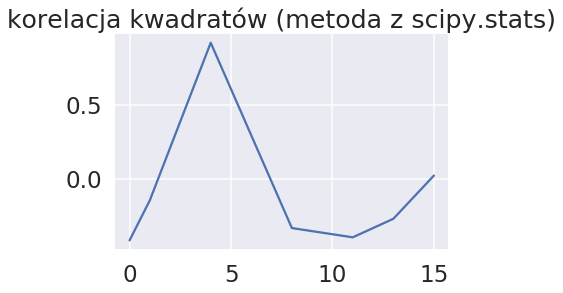

długość korealcji mądrej: 16


In [14]:
'''       TESTY2

    korelacja kwadratów'''


signal = np.array([0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0])
signal2 = np.array([0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0])

signal = signal - np.mean(signal)
signal2 = signal2 - np.mean(signal2)

plt.plot(signal , color = 'red')
plt.plot(signal2)
plt.title("sygały kwadratowe, przesunięte w fazie")
plt.show()
print(f"długość sygnałów {len(signal)}")

kor = koreluj(signal, signal2,len(signal))
plt.plot(kor)
plt.title("Korelacja kwadratów (metoda z zajęć)")
plt.show()
print(f"długość korealcji z zajęć: {len(kor)}, przy delcie = {len(signal)}")

kor2 = cool_koreluj(signal,signal2)
plt.plot(kor2)
plt.title("korelacja kwadratów (metoda z scipy.stats)")
plt.show()

print(f"długość korealcji mądrej: {len(kor2)}")


In [6]:
# !pip3 install -U --upgrade --force-reinstall saffy

2019-10-24 15:16:33,059 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


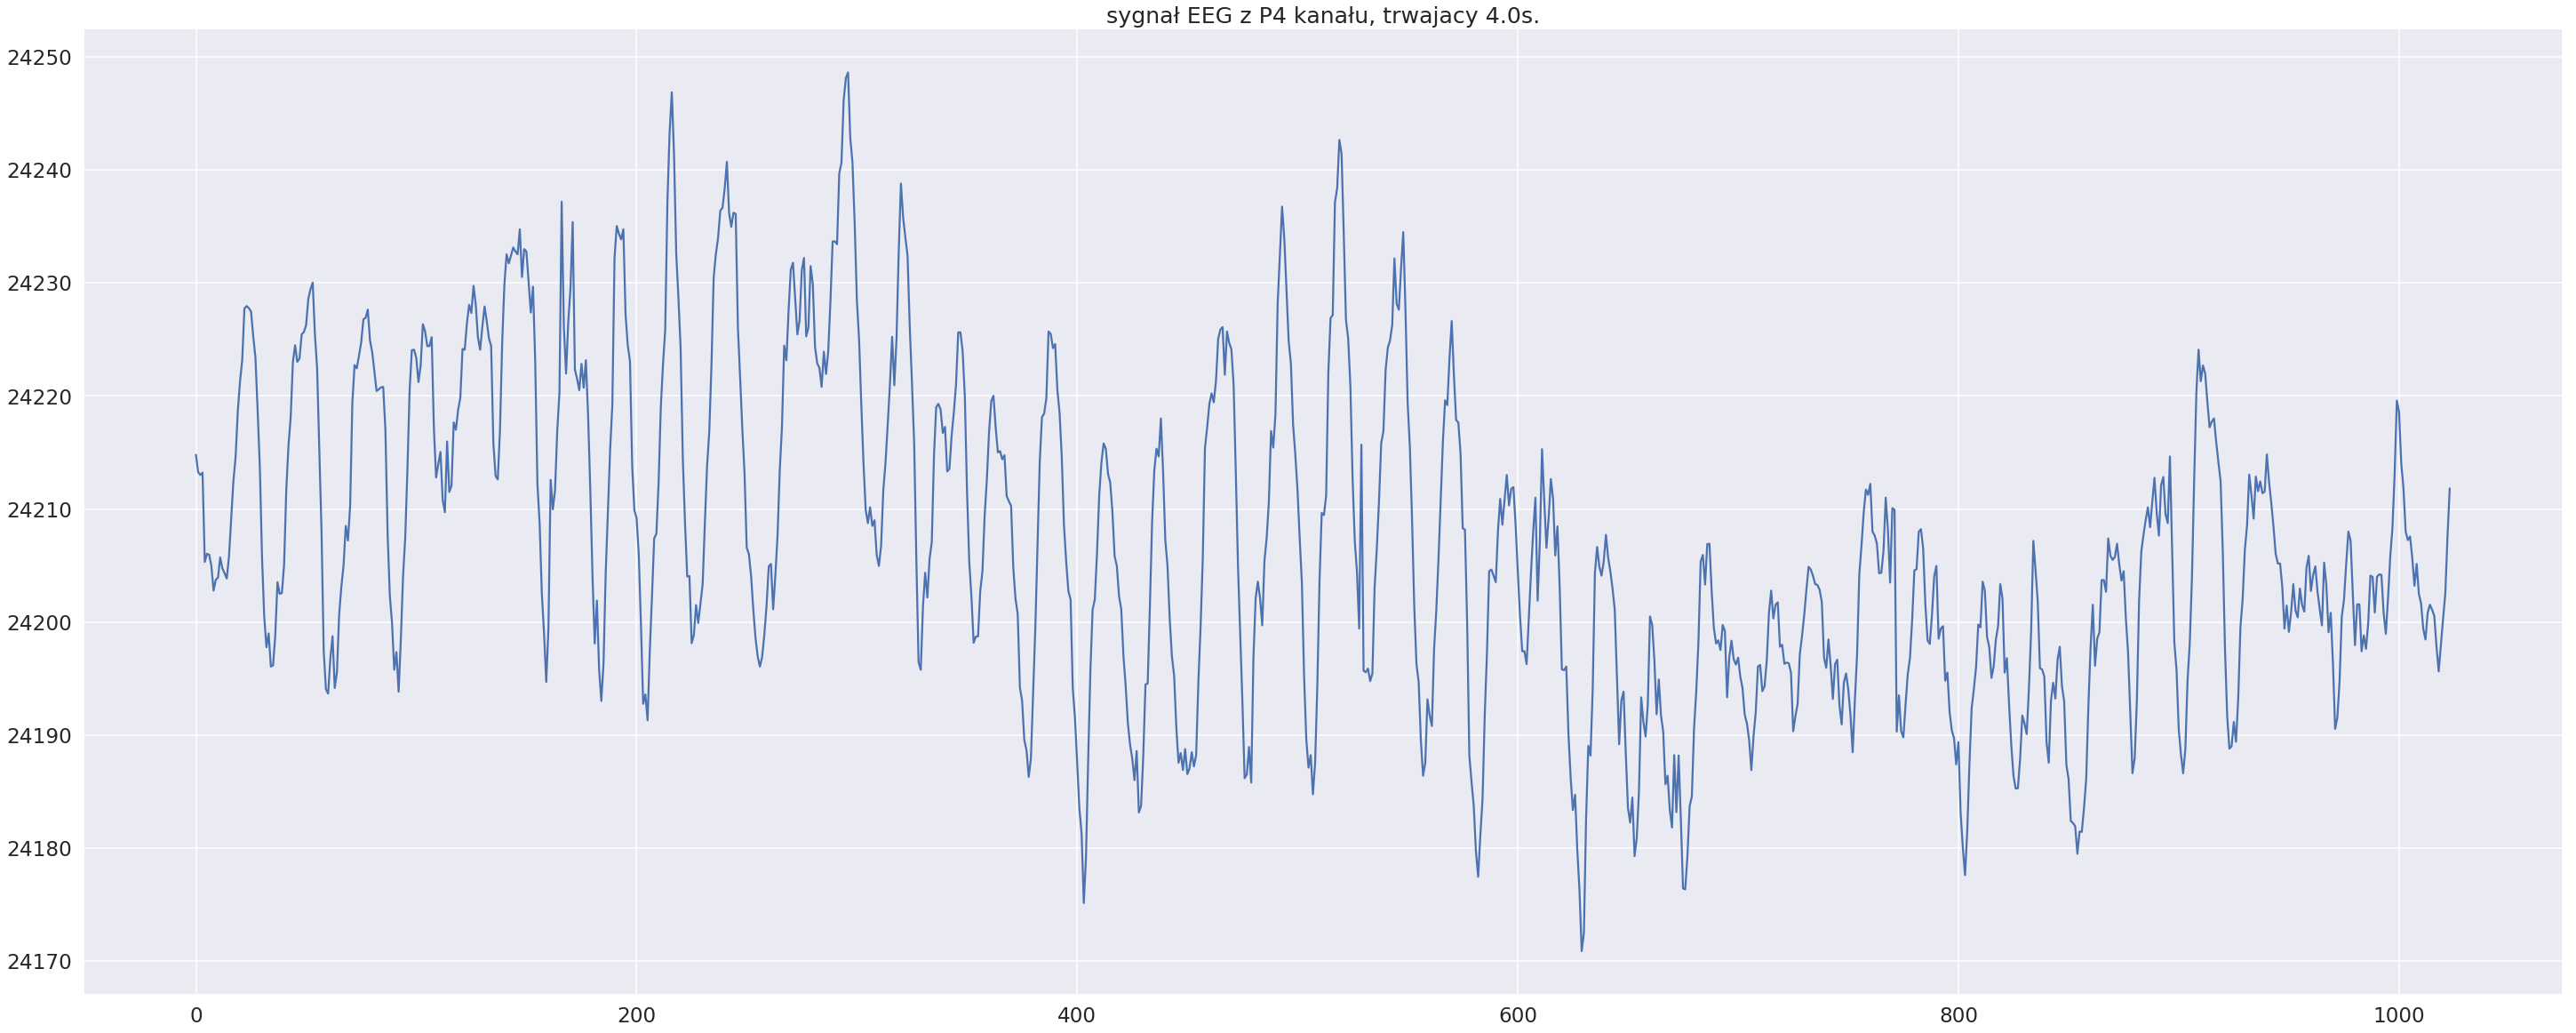

rozmiar naszej macierzy z sygnałami (liczba kanałów , liczba próbek) = (7, 79088) 
Fs:  256


In [16]:
'''Czytanie, montowanie i obróbka sygnałów.
                BEZ FILTRA.'''

pliki = {'open':'mateusz_oczy_szeroko_zamkniete', 'closed':'mateusz_oczy_zamkniete', 'inne':'mateusz_try1'}
fig = plt.figure(figsize = (50,20))

EEG = saffy.SignalManager(generator=svarog(pliki['closed']))
# EEG.butter_highpass_filter(cutoff=1, order=2)
# EEG.cheb2_notch_filter(cutoff=50, order=1, rs=3, width=0.3, btype='bandstop')

CH = ['Fp1', 'P3', 'Pz', 'P4', 'Fp2', 'O1', 'O2','A1','A2']
EEG.extract_channels(CH)

EEG_2D = EEG.data[0,:,:] #jest tylko jeden zestaw danych
EEG_2D = EEG_2D - (EEG_2D[-1,:] + EEG_2D[-2,:])/2 #montaz - średnia z uszu   
EEG_2D = EEG_2D[0:-2,:] #usuwamy kanały uszne

CH_N = EEG_2D.shape[0]
kanał = 3
próbki = 1024

DELTA = 1500
START = 1000
STOP = 2500

plt.plot(EEG_2D[kanał,:próbki])
plt.title(f"sygnał EEG z {CH[kanał]} kanału, trwajacy {próbki/EEG.fs}s.")
plt.show()
print(f"rozmiar naszej macierzy z sygnałami (liczba kanałów , liczba próbek) = {EEG_2D.data.shape} ")
print('Fs: ', EEG.fs)

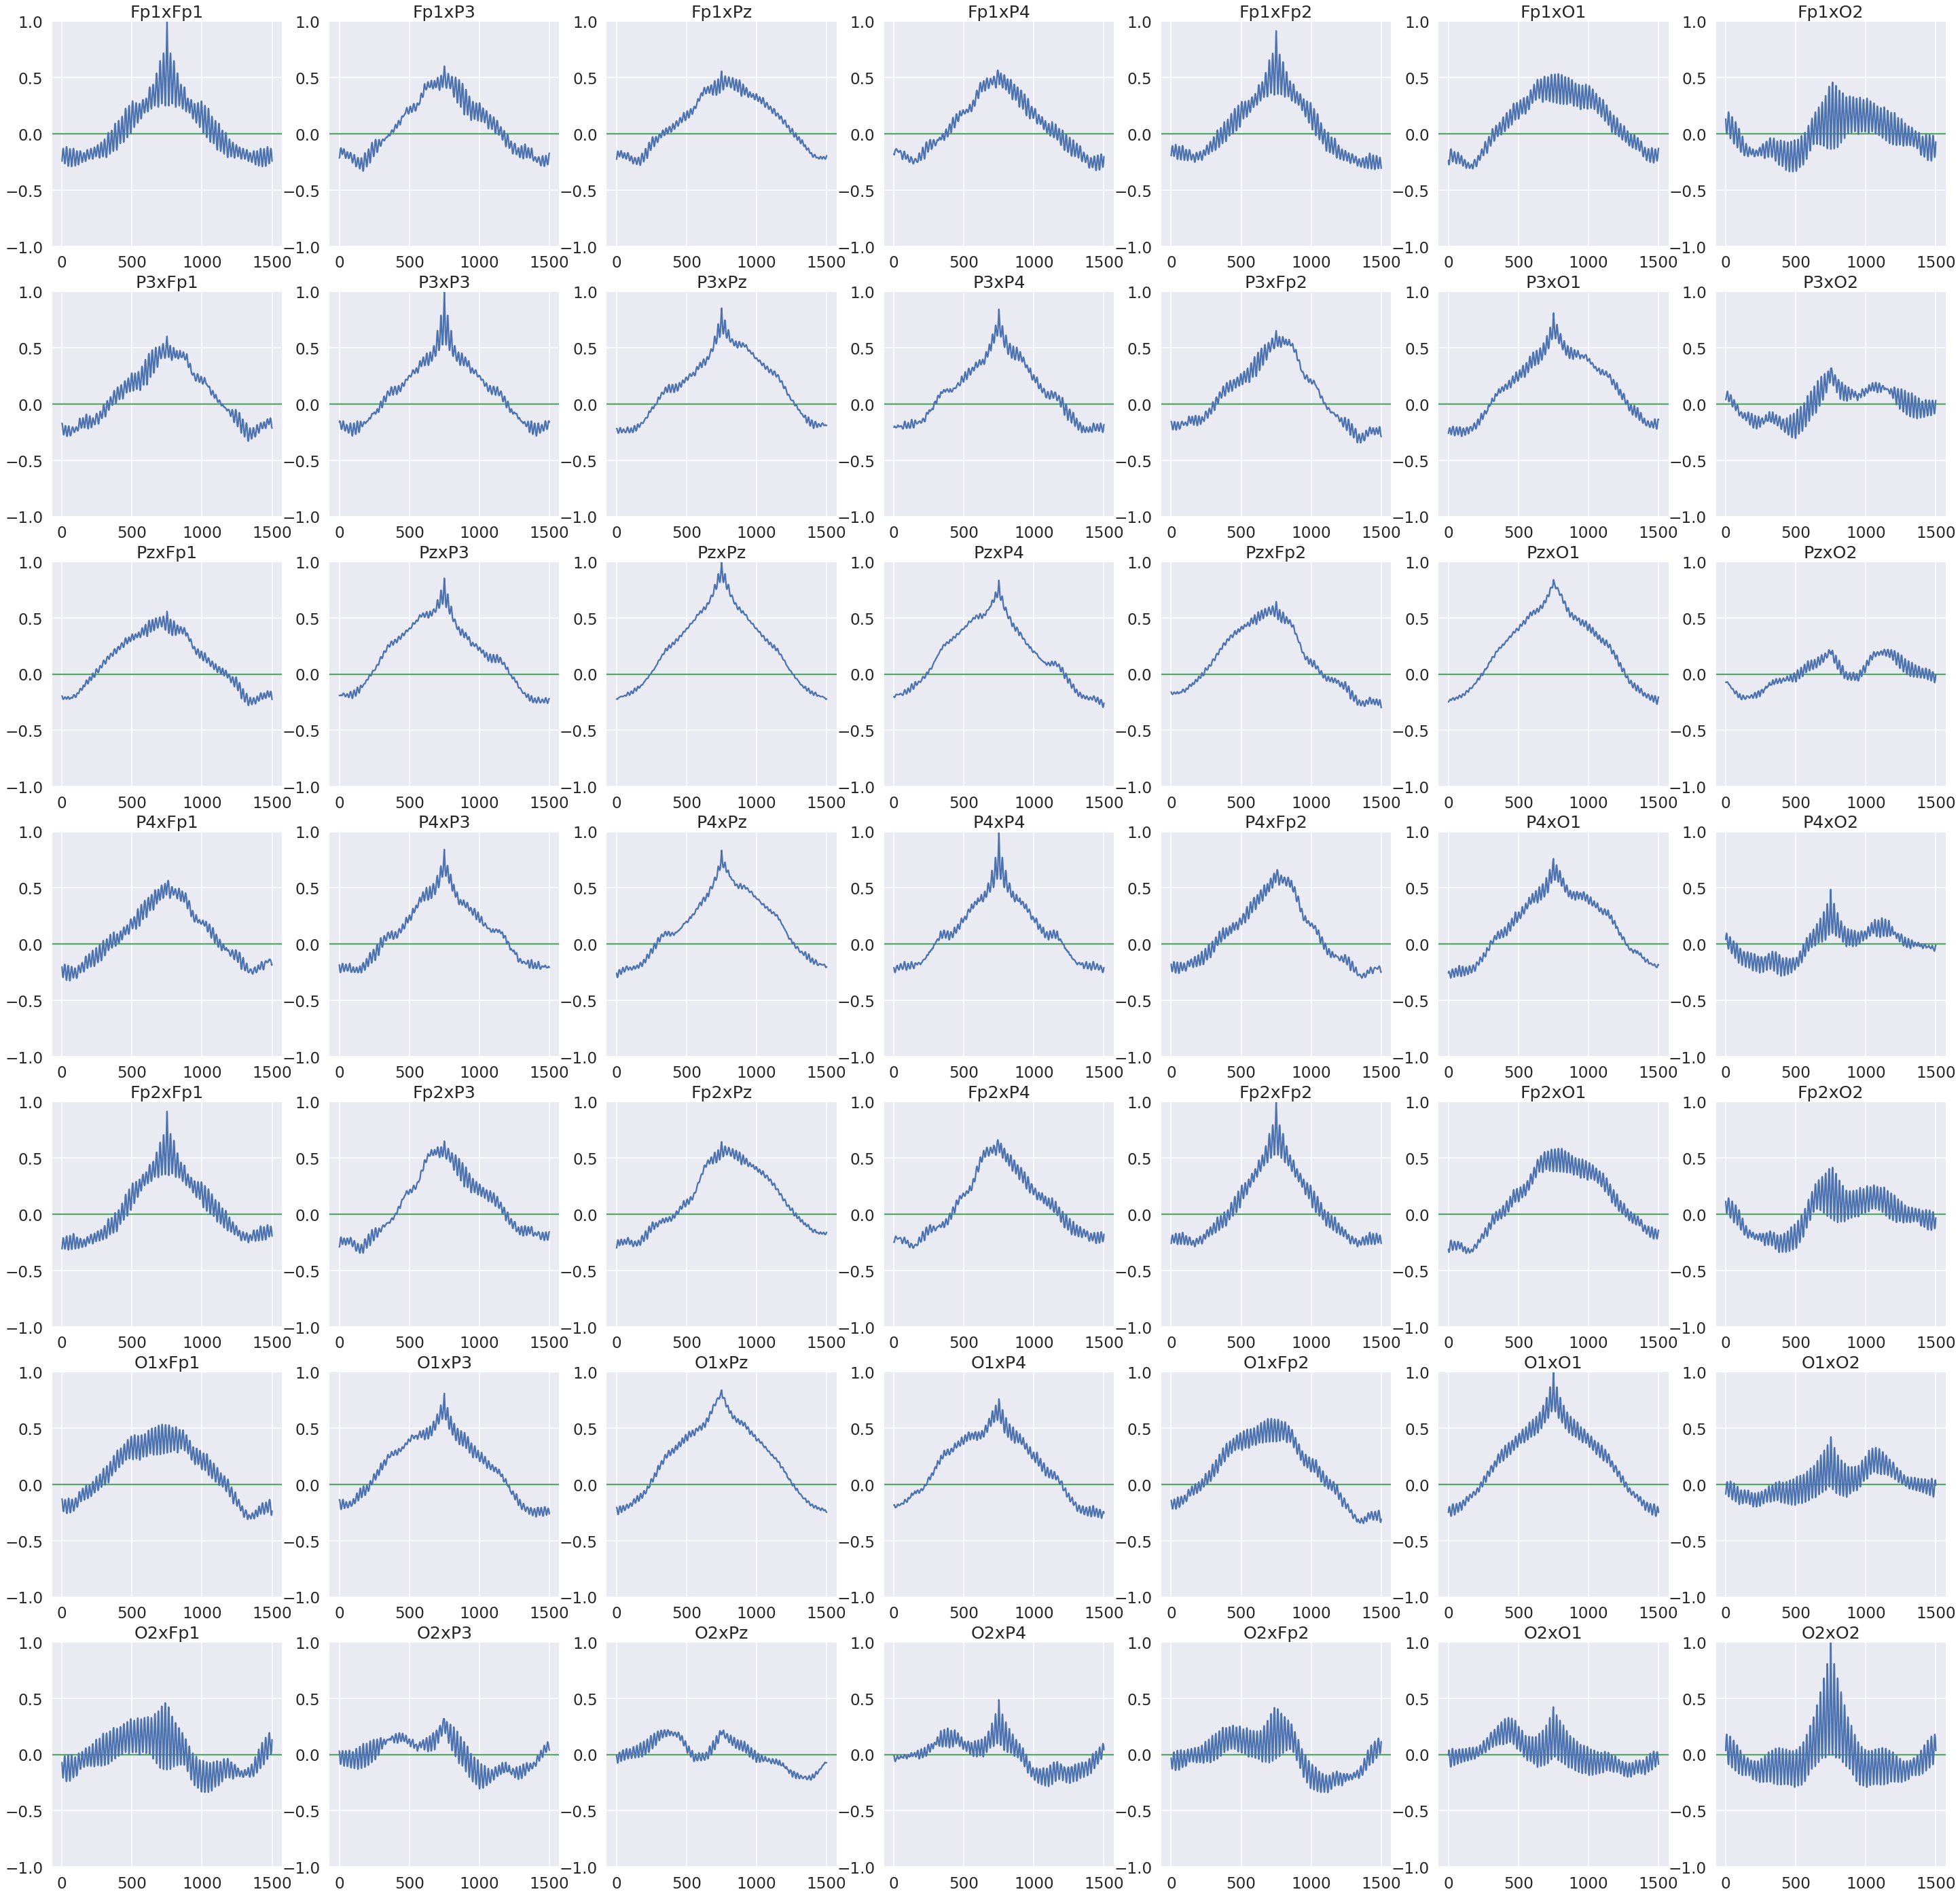

In [17]:
'''Korelacje metodą funkcji napisanej na zajęciach.
                Długo się liczy.
                BEZ FILTRA.'''
fig = plt.figure(figsize = (50,50))
K = rysuj_koreluj(EEG_2D , CH , CH_N , DELTA , START , STOP)

In [18]:
'''Poziom istotności.
    BEZ FILTRA.'''
eN = 1000

max_k , up , down = przedzialy(EEG_2D , CH_N , START , STOP , eN)
print(up , down)

0.11799721809587382 -0.11799721809587382


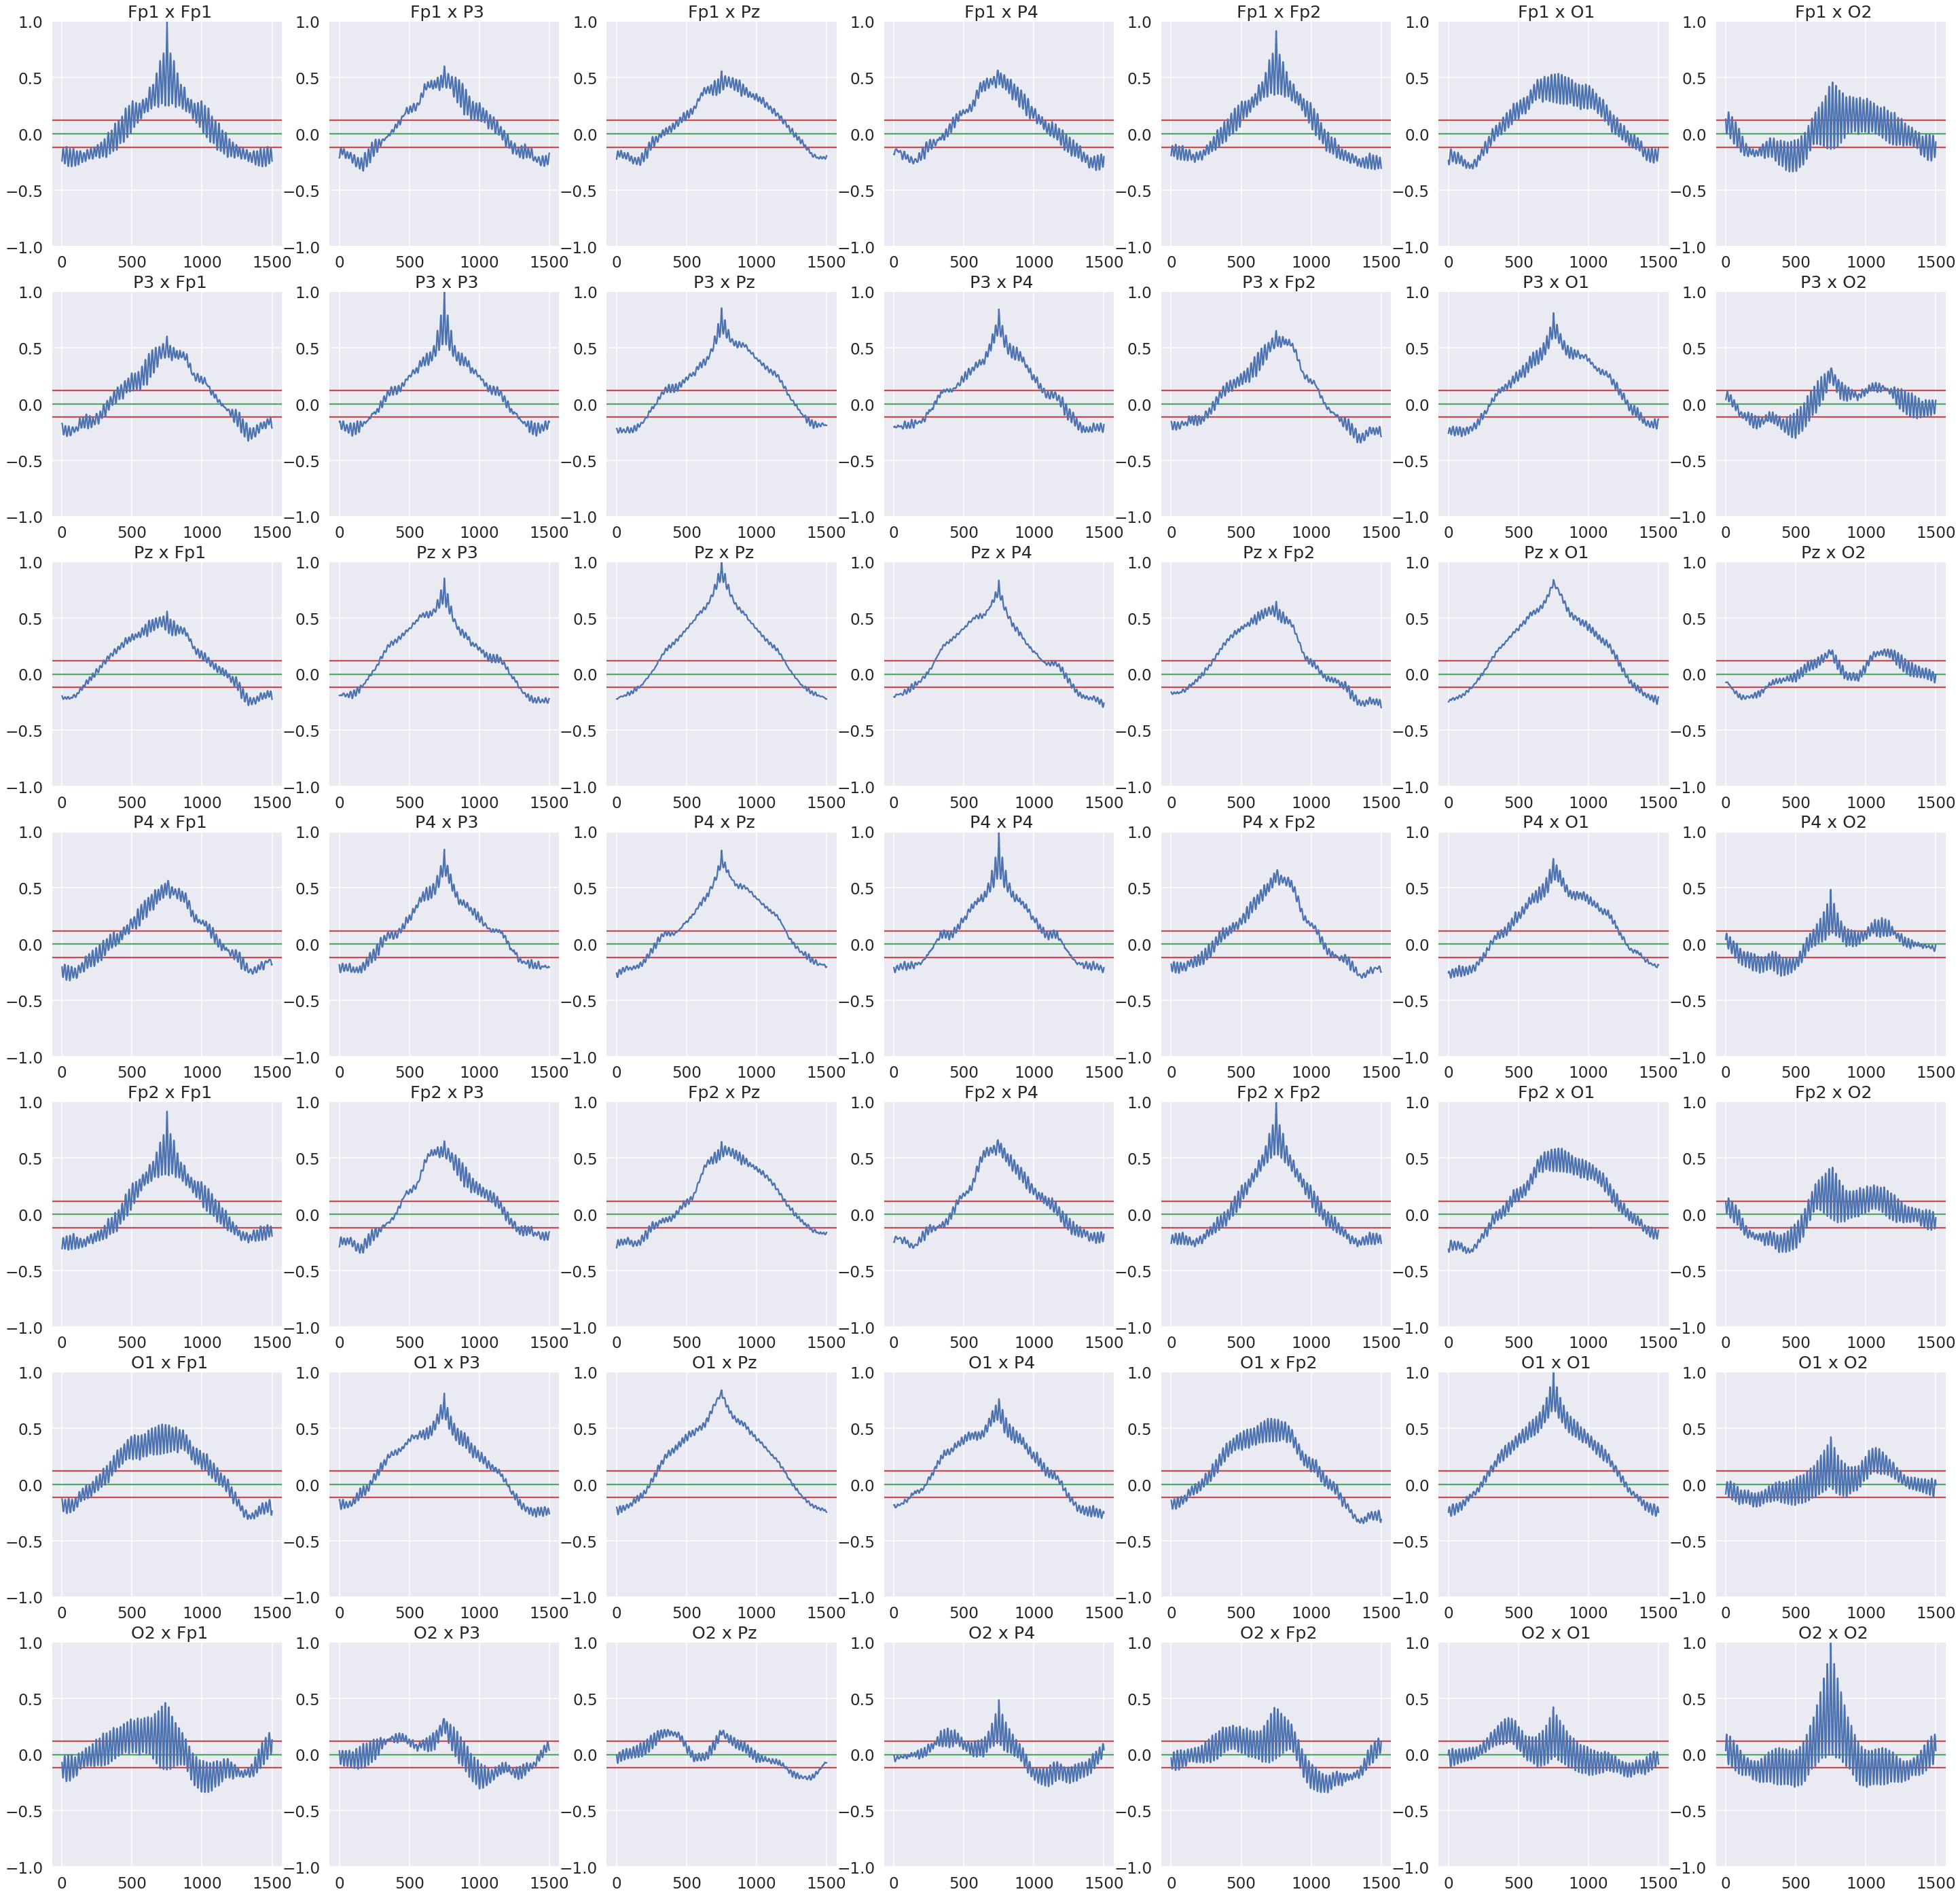

<Figure size 3600x3600 with 0 Axes>

In [19]:
''' Korealcje metodą mądrą z scipy.stats , normalizacją i odejmowaniem średniej. Z przedziałami ufności.
                            Liczy sie szybko.
                            BEZ FILTRA.'''
fig = plt.figure(figsize = (50,50))
K2 = rysuj_cool_koreluj(EEG_2D , CH , CH_N , START , STOP , up , down)

In [24]:
''' Zabawa z przefiktrowanym sygnałem
                FILTROWANIE'''
EEG2 = saffy.SignalManager(generator=svarog(pliki['closed']))
EEG2.butter_bandpass_filter(lowcut=8, highcut=12, order=5, method=None)
EEG2.extract_channels(CH)
EEG_2D_F = EEG2.data[0,:,:] #jest tylko jeden zestaw danych
EEG_2D_F = EEG_2D_F - (EEG_2D_F[-1,:] + EEG_2D_F[-2,:])/2 #montaz - średnia z uszu   
EEG_2D_F = EEG_2D_F[0:-2,:] #usuwamy kanały uszne



2019-10-24 15:18:25,470 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


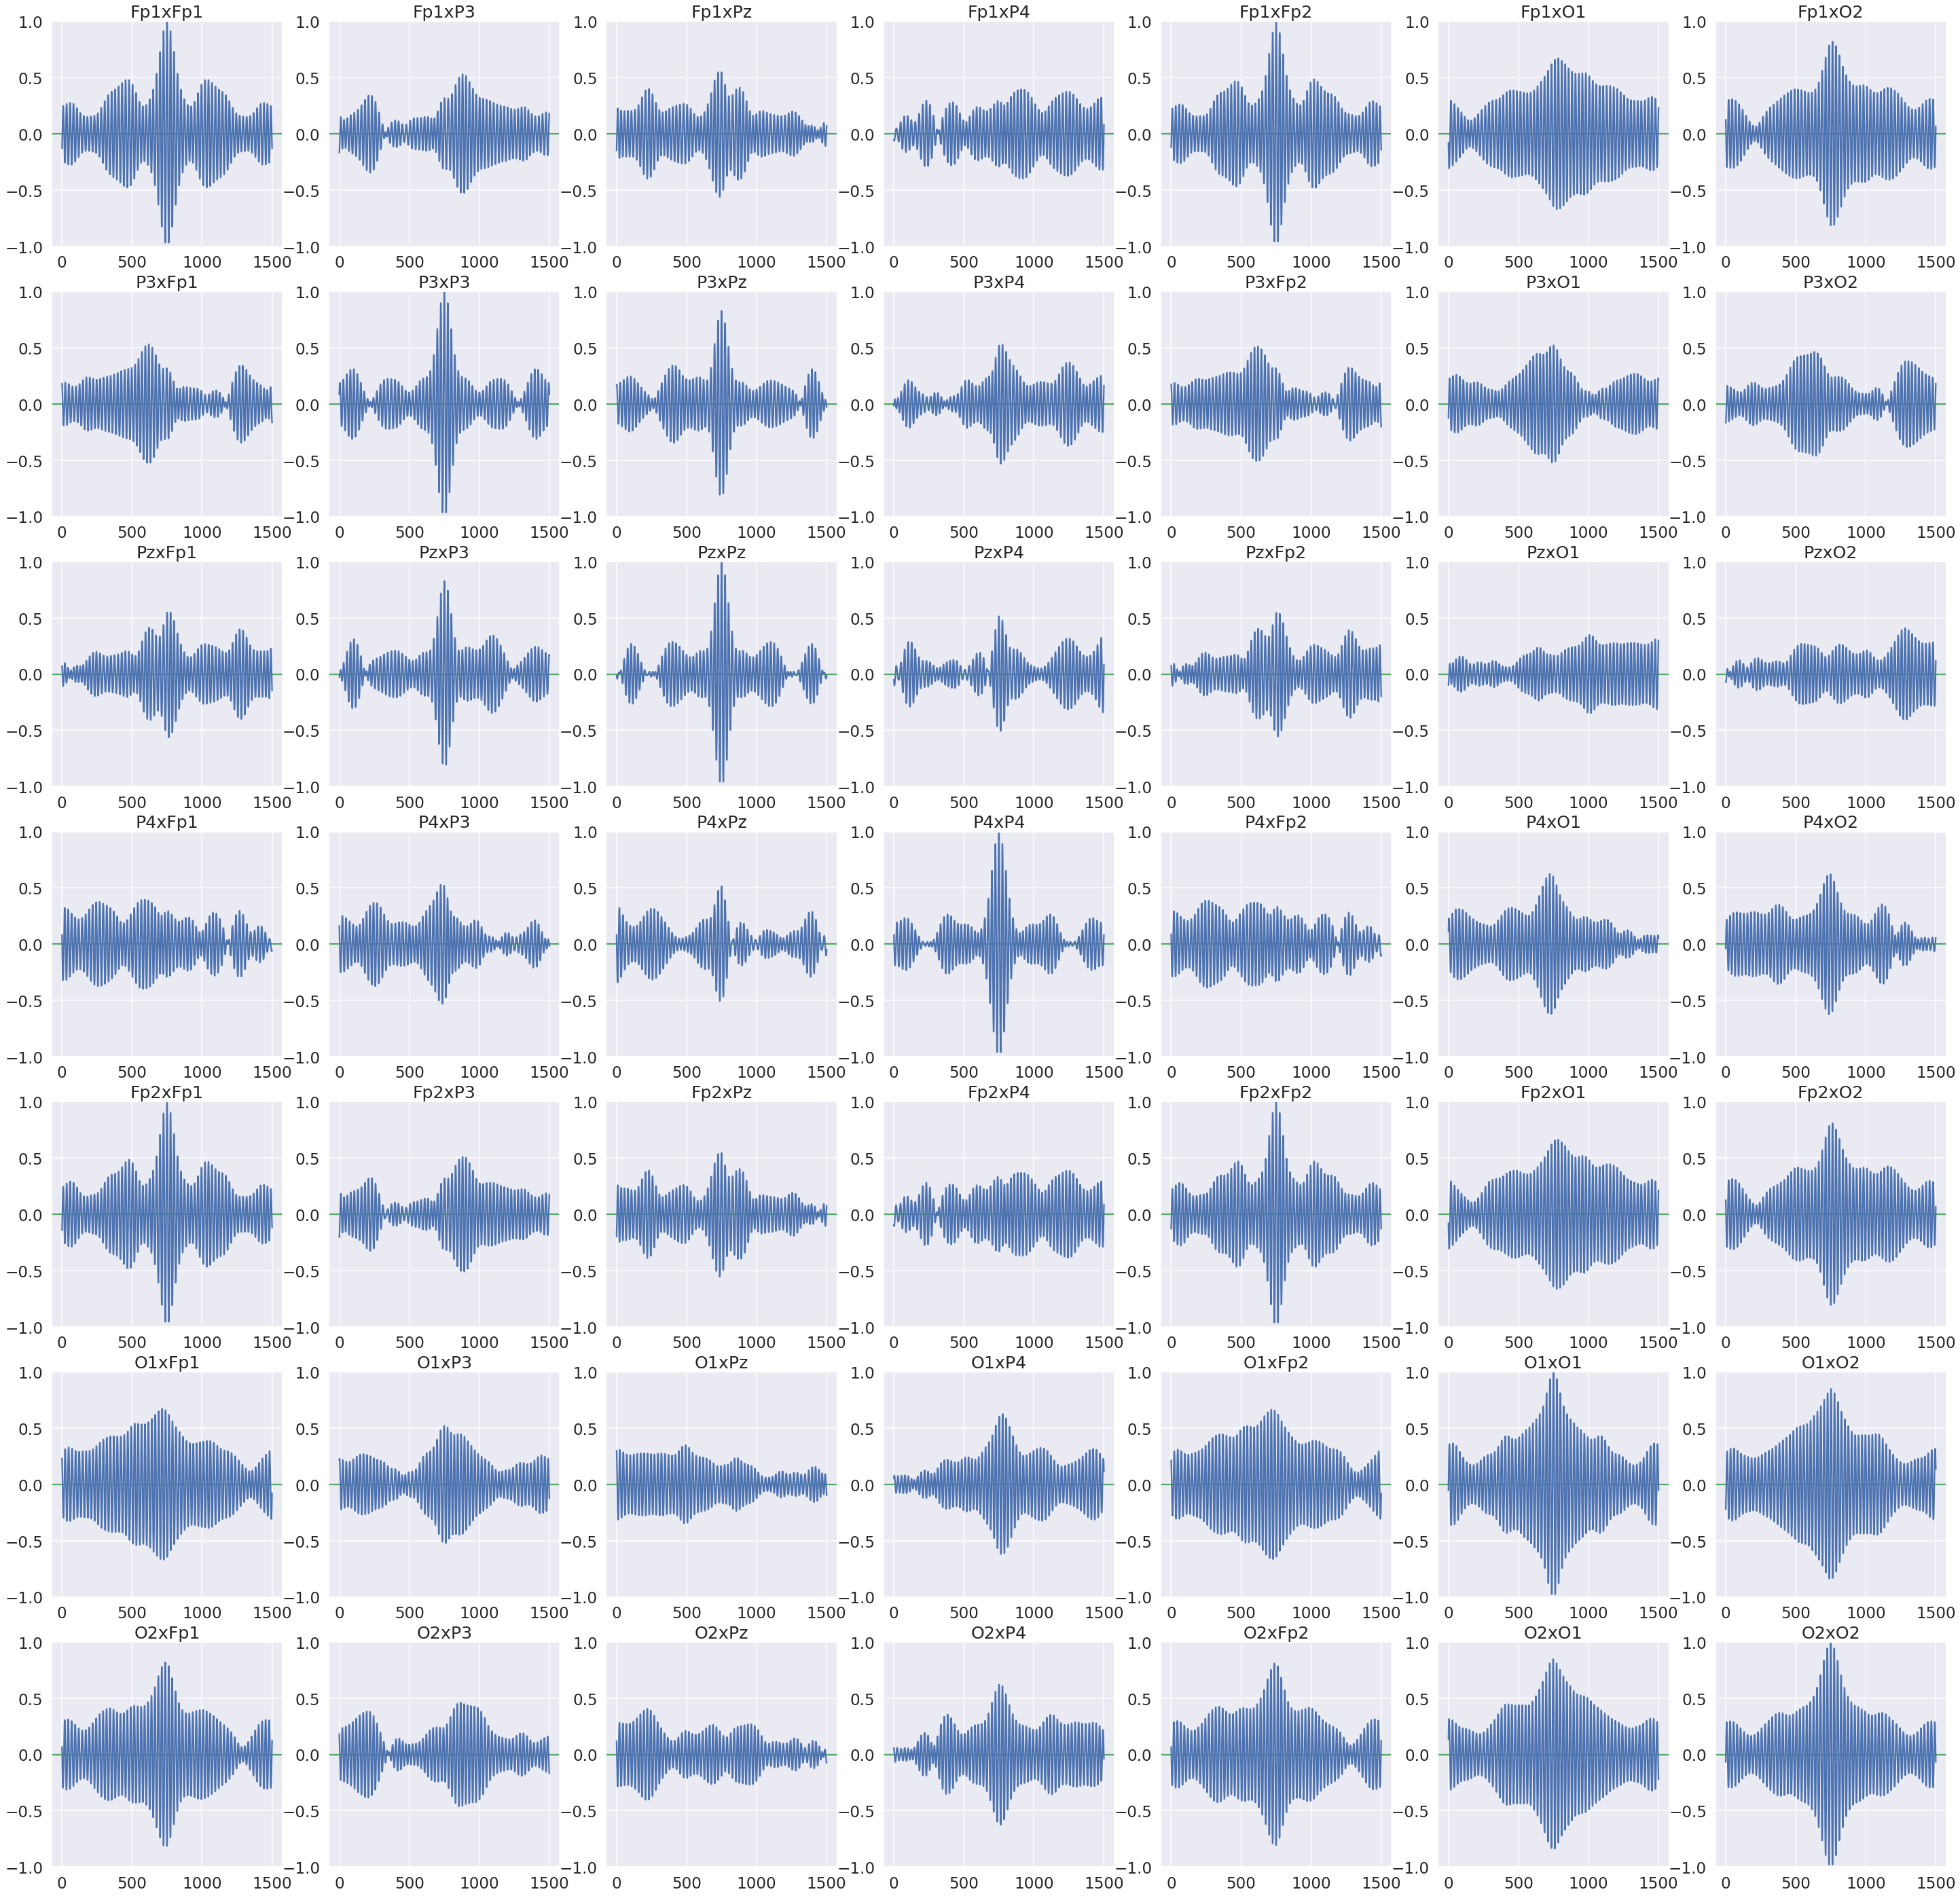

In [25]:
'''Korelacje metodą funkcji napisanej na zajęciach.
                Długo się liczy.
                Z FILTREM.'''
fig = plt.figure(figsize = (50,50))
K_filtrowane = rysuj_koreluj(EEG_2D_F , CH , CH_N , DELTA , START , STOP)

In [26]:
'''Poziom istotności.
    Z FILTREM.'''
max_k_filtrowane , up_filt , down_filt = przedzialy(EEG_2D_F , CH_N , START , STOP , eN)
print(up_filt , down_filt)

0.11851035014062804 -0.11851035014062804


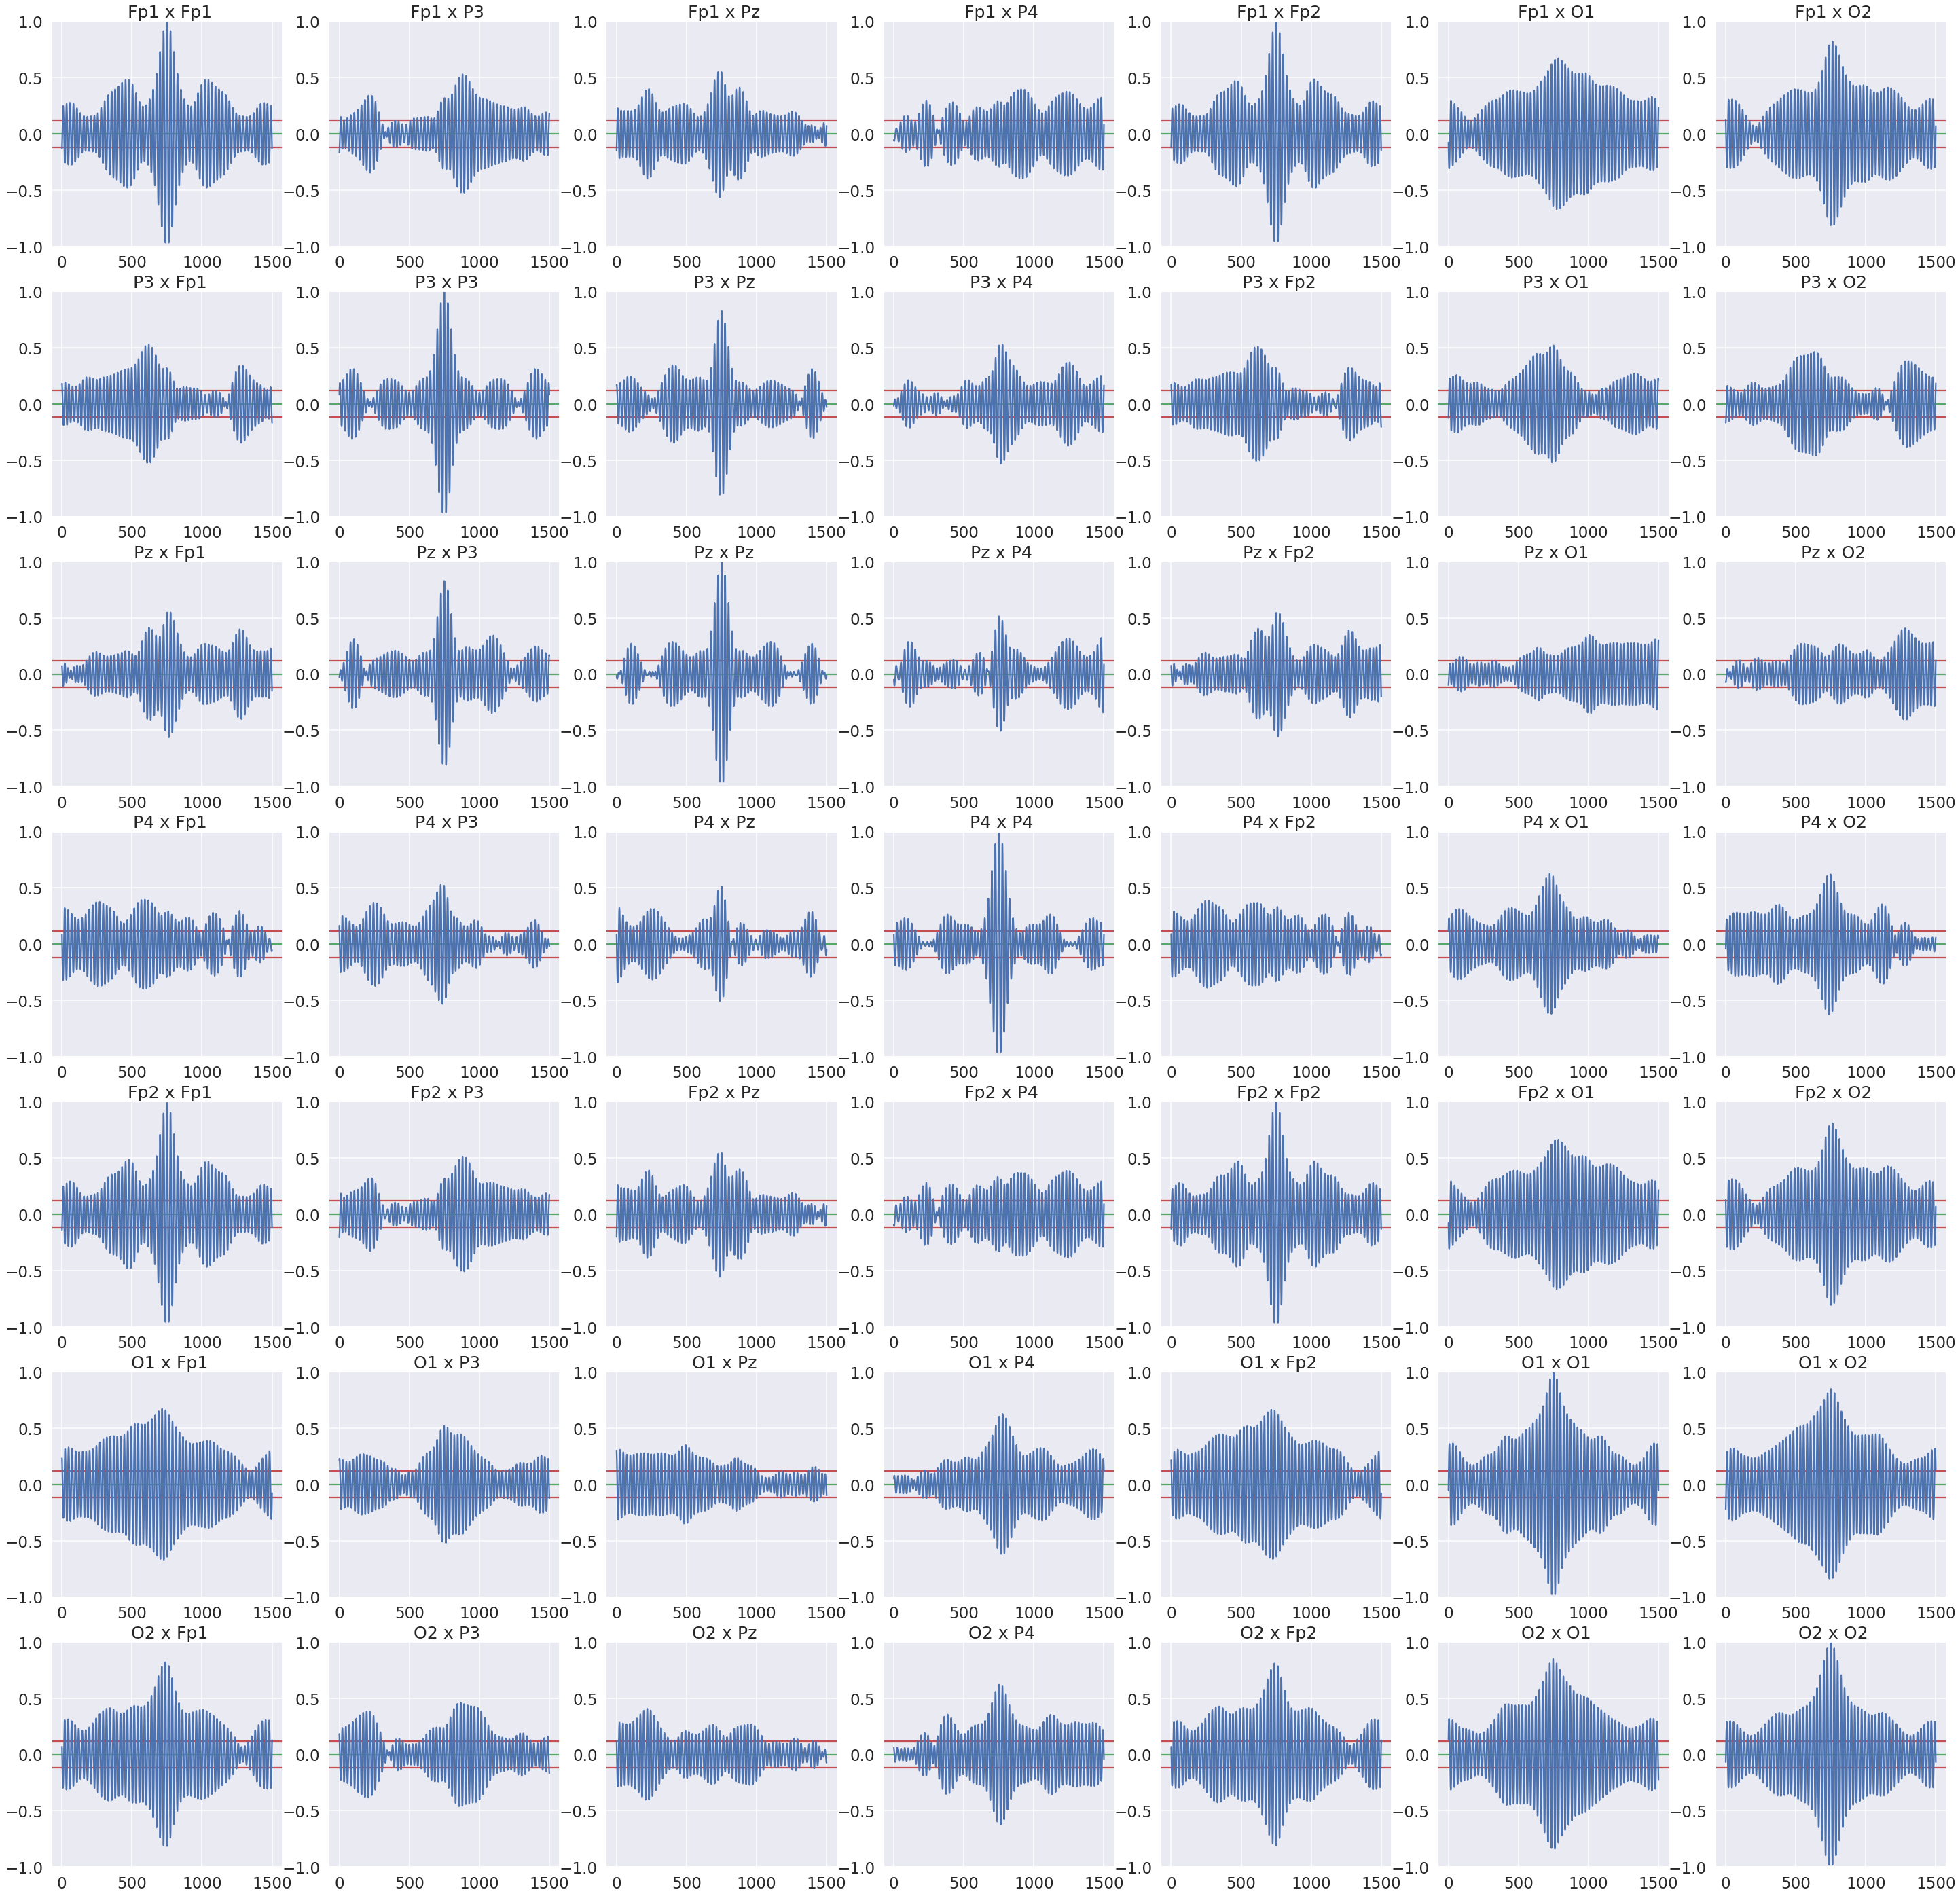

<Figure size 3600x3600 with 0 Axes>

In [27]:
''' Korealcje metodą mądrą z scipy.stats , normalizacją i odejmowaniem średniej.
                            Liczy sie szybko.
                            Z FILTREM'''
fig = plt.figure(figsize = (50,50))
K2_filtrowane = rysuj_cool_koreluj(EEG_2D_F , CH , CH_N , START , STOP , up_filt , down_filt)

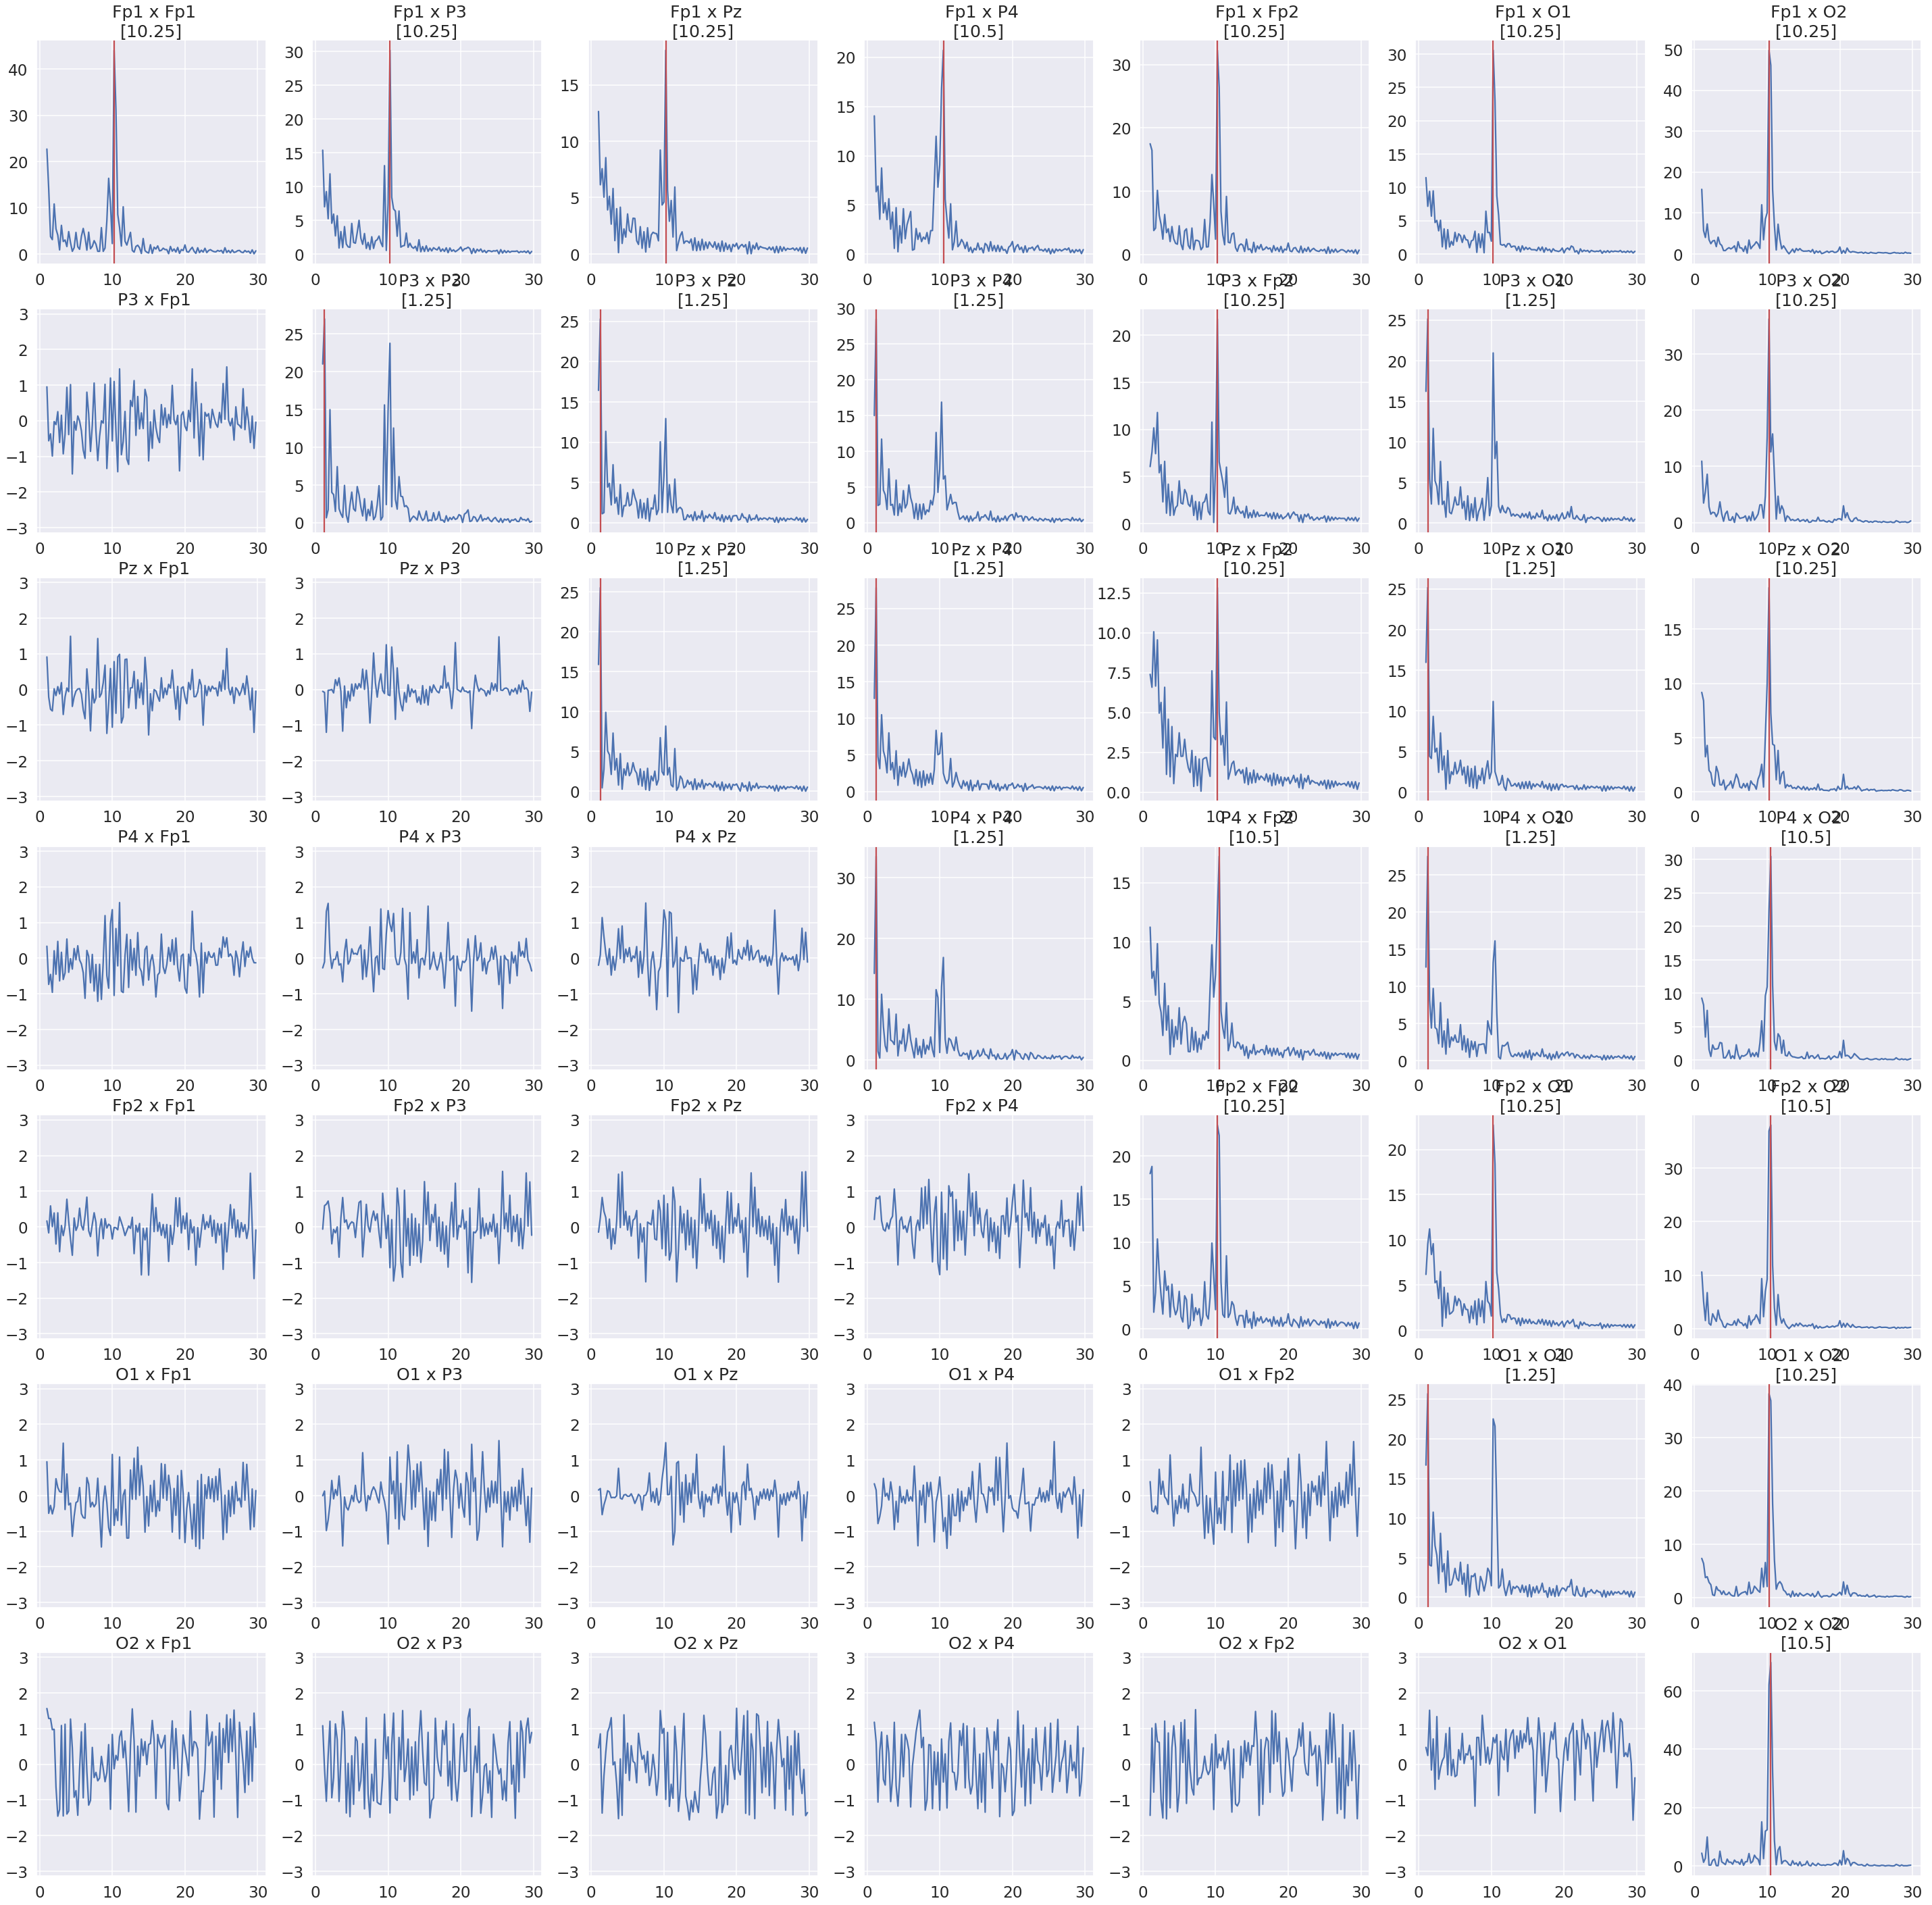

In [55]:
F = np.arange(1 , 30, .25)
fig = plt.figure(figsize = (50,50))
Fs = EEG.fs
for i in range(CH_N):
    for j in range(CH_N):
        Fr , Fr2 = fourier(K2[i,j], F , Fs)
        if i <= j:
            plt.subplot( CH_N , CH_N , ( (i*CH_N) + j+1 ) )
            plt.title(f" {CH[i]} x {CH[j]}" + '\n' +str(F[np.where(Fr == np.max(Fr))]) )
            plt.plot(F , Fr)
            plt.axvline(F[np.where(Fr == np.max(Fr))], color = 'r')
        else:
            Sigma = np.arctan(Fr2.imag/Fr2.real)
            plt.subplot( CH_N , CH_N , ( (i*CH_N) + j+1 ) )
            plt.title(f" {CH[i]} x {CH[j]}")
            plt.plot(F, Sigma)
            plt.ylim(-np.pi , np.pi)
plt.show()



In [34]:
print(len(K2[0,1]))
print(K2[0,1][750])
print(K2[1,0][750])

1501
0.6014955084019421
0.6014955084019421


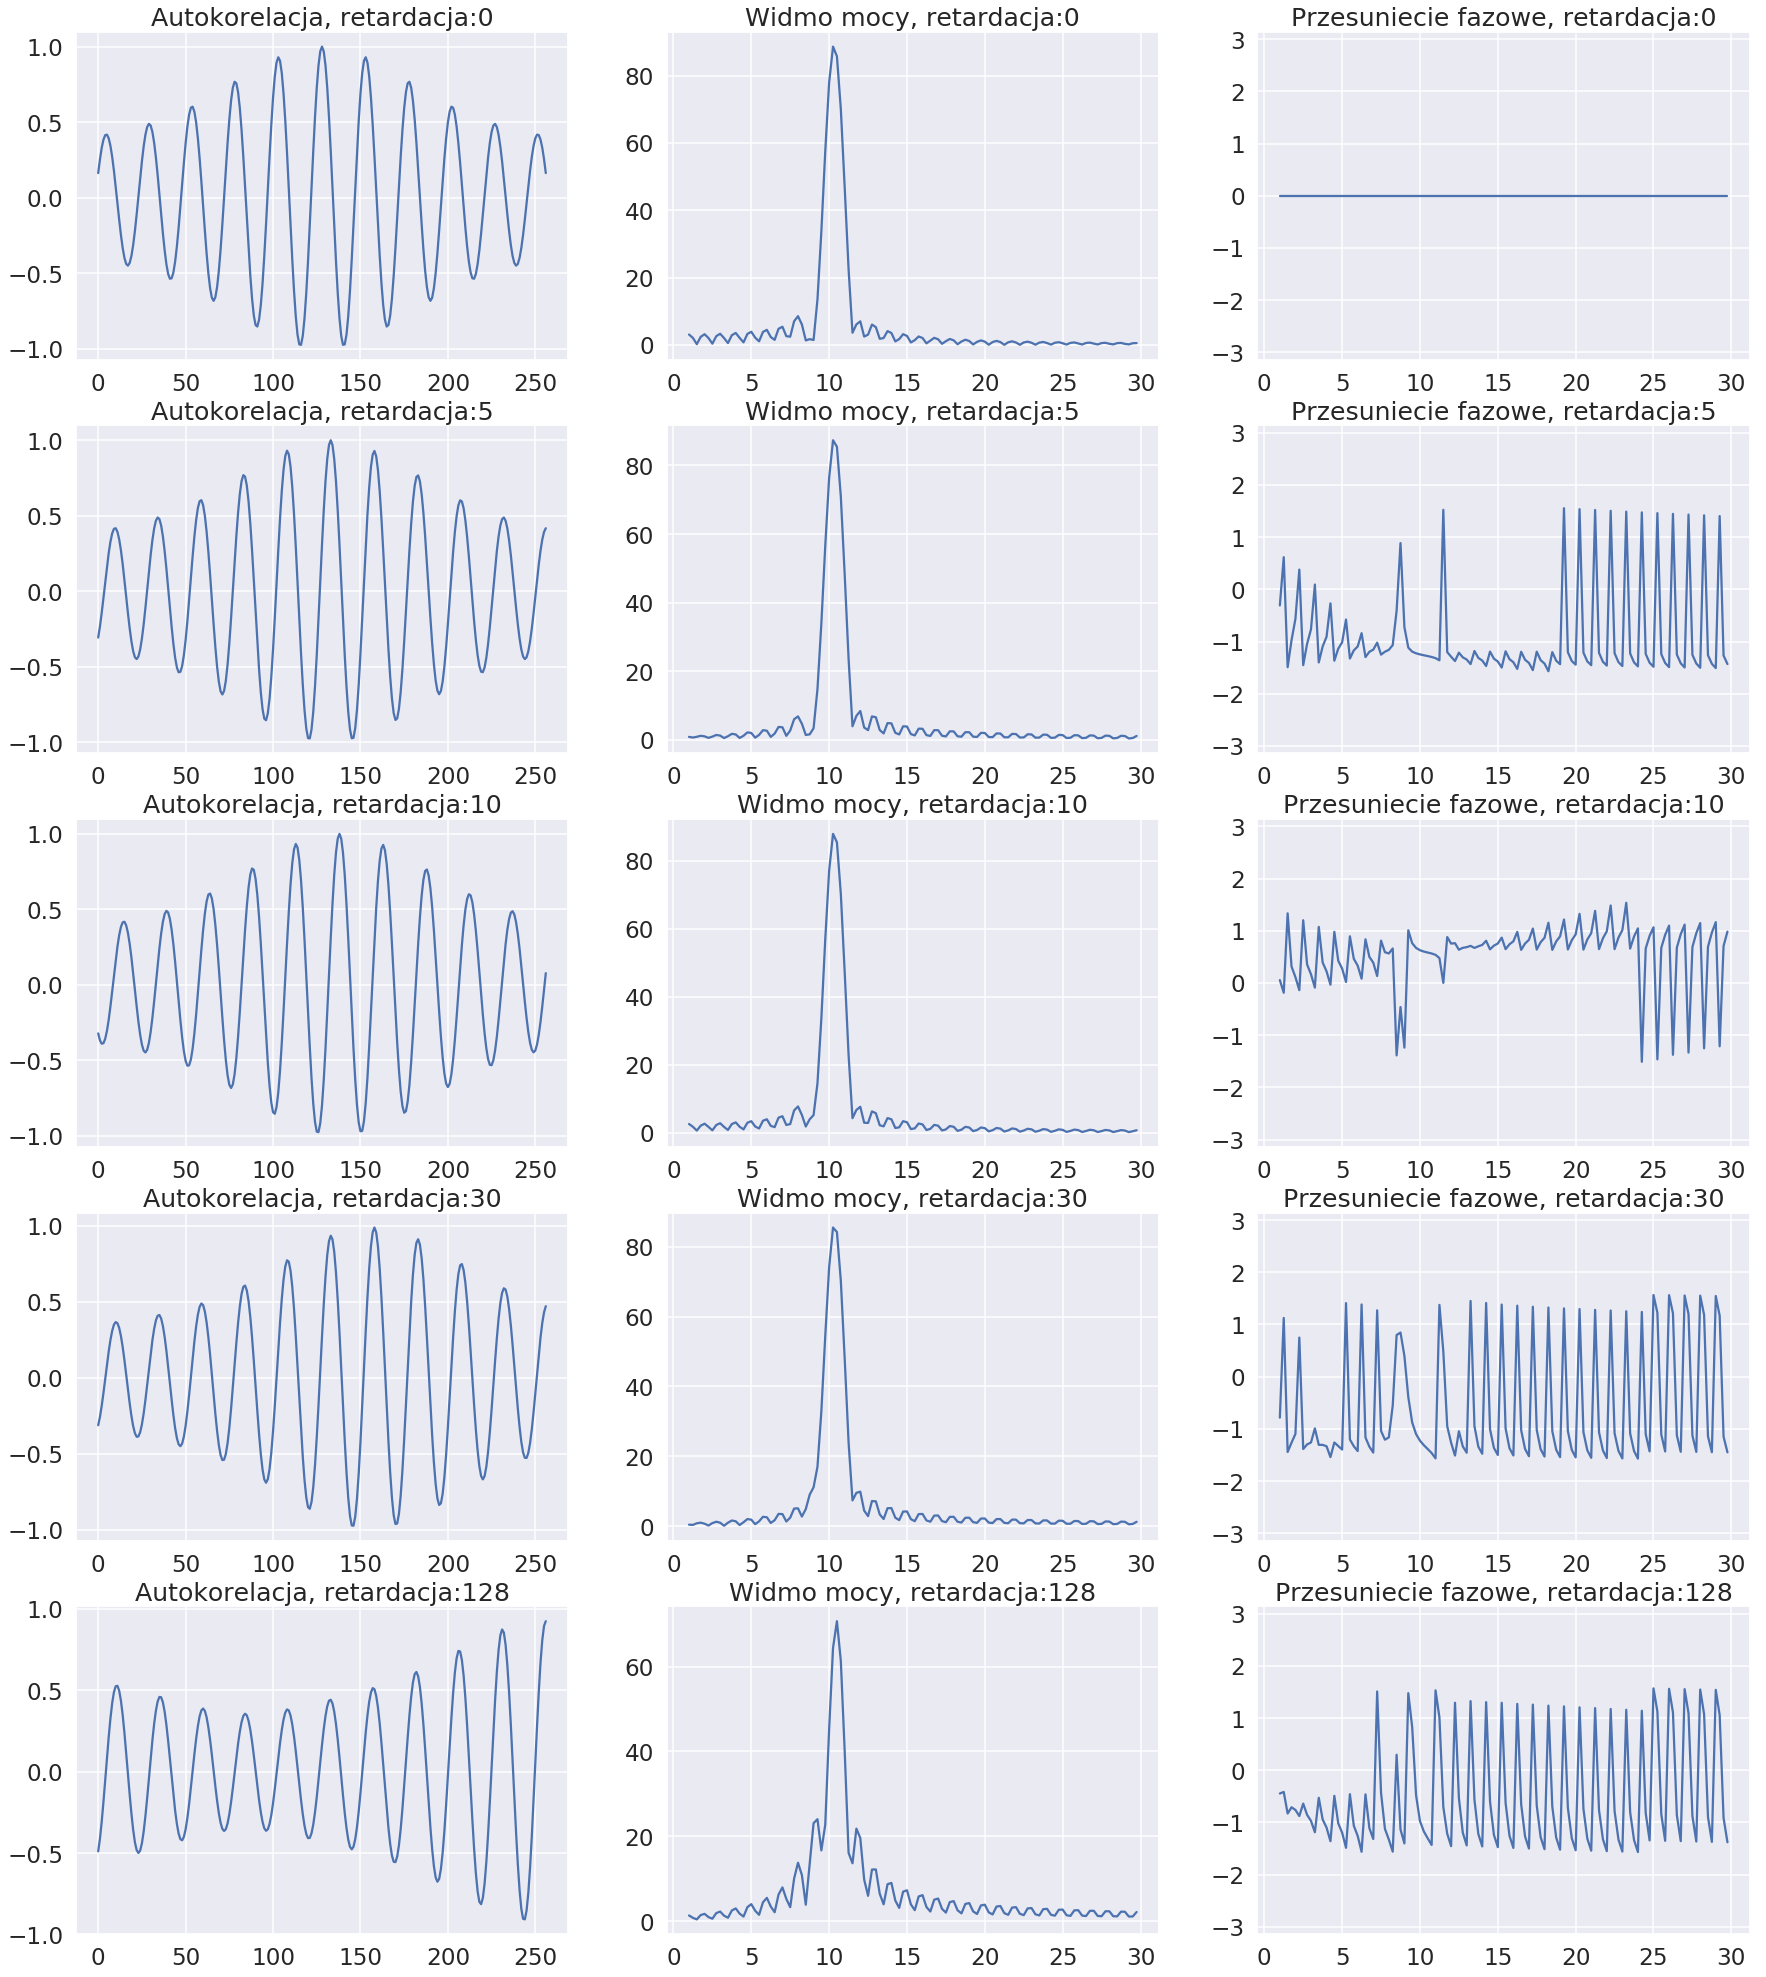

In [73]:
retardacja = [0,5,10,30, int(Fs/2)]
F = np.arange(1 , 30, .25)
start = 1000
stop = 3000
fig = plt.figure(figsize = (30,35))
for k in range(len(retardacja)):
    signal0 = EEG_2D_F[0][start:stop]
    signal1 = EEG_2D_F[0][start + retardacja[k]:stop + retardacja[k]]
    plt.subplot(len(retardacja),3 , 1+3*k)
    corelation = koreluj(signal0, signal1, Fs)
    plt.plot(corelation)
    plt.title('Autokorelacja, retardacja:' + f"{retardacja[k]}" )
    plt.subplot(len(retardacja),3 , 2+3*k)
    Fr , Fr2 = fourier(corelation, F , Fs)
    plt.plot(F, Fr)
    plt.title('Widmo mocy, retardacja:' + f"{retardacja[k]}" )
    plt.subplot(len(retardacja),3 , 3+3*k)
    Sigma = np.arctan(Fr2.imag/Fr2.real)
    plt.plot(F, Sigma)
    plt.title('Przesuniecie fazowe, retardacja:' + f"{retardacja[k]}" )
    plt.ylim(-np.pi , np.pi)
plt.show()


    